<a href="https://colab.research.google.com/github/AnnAnsas/Pet-Project/blob/main/Demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
store_sales = pd.read_csv("train.csv")
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Check for null values

In [5]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116006 entries, 0 to 116005
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    116006 non-null  object
 1   store   116006 non-null  int64 
 2   item    116006 non-null  int64 
 3   sales   116006 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.5+ MB


In [6]:
store_sales.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
store_sales.describe()

,store,item,sales
count,116006.000000,116006.000000,116006.000000
mean,5.322207,3.694481,37.551497
std,2.896336,1.843228,22.771950
min,1.000000,1.000000,0.000000
25%,3.000000,2.000000,20.000000
50%,5.000000,4.000000,31.000000
75%,8.000000,5.000000,51.000000
max,10.000000,7.000000,150.000000


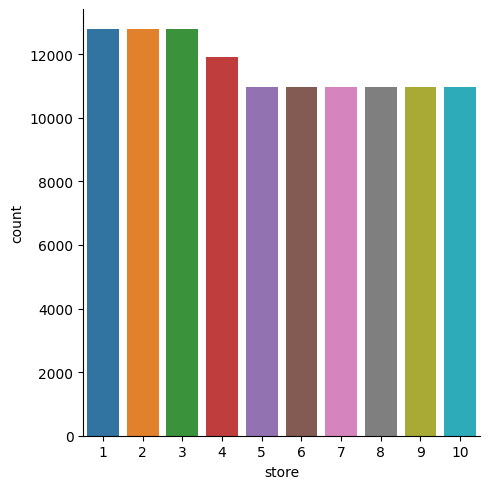

In [8]:
import seaborn as sns

sns.catplot(data = store_sales, x = "store", kind = "count")

In [9]:
store_sales["store"].value_counts(normalize=True)

1     0.110184
2     0.110184
3     0.110184
4     0.102788
5     0.094443
6     0.094443
7     0.094443
8     0.094443
9     0.094443
10    0.094443
Name: store, dtype: float64

In [10]:
store_sales["item"].value_counts(normalize=True)

1    0.157406
2    0.157406
3    0.157406
4    0.157406
5    0.157406
6    0.157406
7    0.055566
Name: item, dtype: float64

Converting date to date datatype

In [12]:
store_sales["date"] = pd.to_datetime(store_sales["date"])

Date to month period and sum items in month

In [13]:
store_sales["date"] = store_sales["date"].dt.to_period('M')
monthly_sales = store_sales.groupby("date").sum().reset_index()

In [14]:
monthly_sales["date"] = monthly_sales["date"].dt.to_timestamp()
monthly_sales.head(12)

,date,sales
0,2013-01-01,41853
1,2013-02-01,42806
2,2013-03-01,57136
3,2013-04-01,62912
4,2013-05-01,70621
5,2013-06-01,73932
6,2013-07-01,79070
7,2013-08-01,71204
8,2013-09-01,63559
9,2013-10-01,60969


Let's see what we have by now

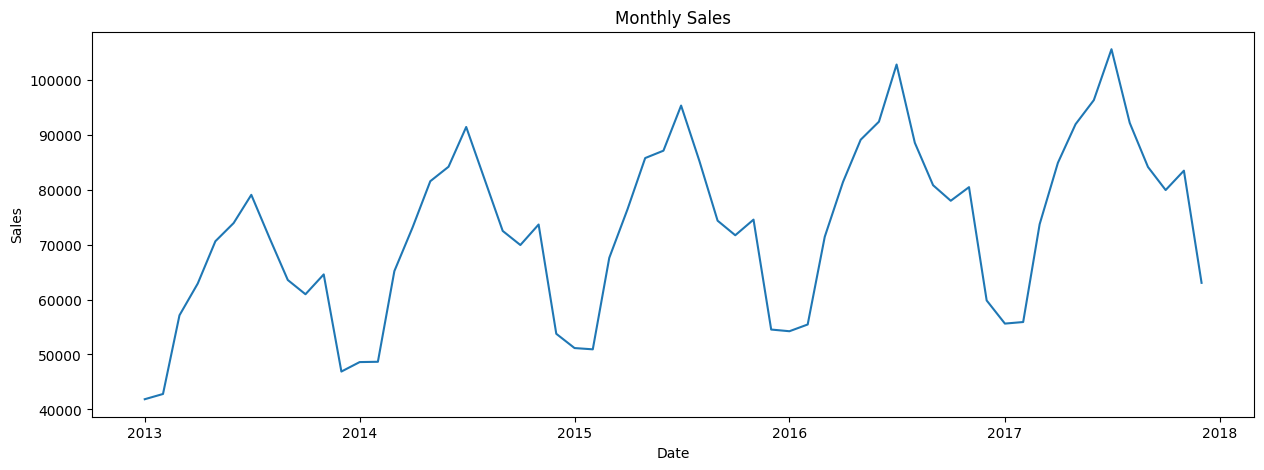

In [15]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Sales")
plt.show()

Call the difference on the sales columns to make the sales data stationery

In [16]:
monthly_sales["sales_diff"] = monthly_sales["sales"].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(12)

,date,sales,sales_diff
1,2013-02-01,42806,953.0
2,2013-03-01,57136,14330.0
3,2013-04-01,62912,5776.0
4,2013-05-01,70621,7709.0
5,2013-06-01,73932,3311.0
6,2013-07-01,79070,5138.0
7,2013-08-01,71204,-7866.0
8,2013-09-01,63559,-7645.0
9,2013-10-01,60969,-2590.0
10,2013-11-01,64581,3612.0


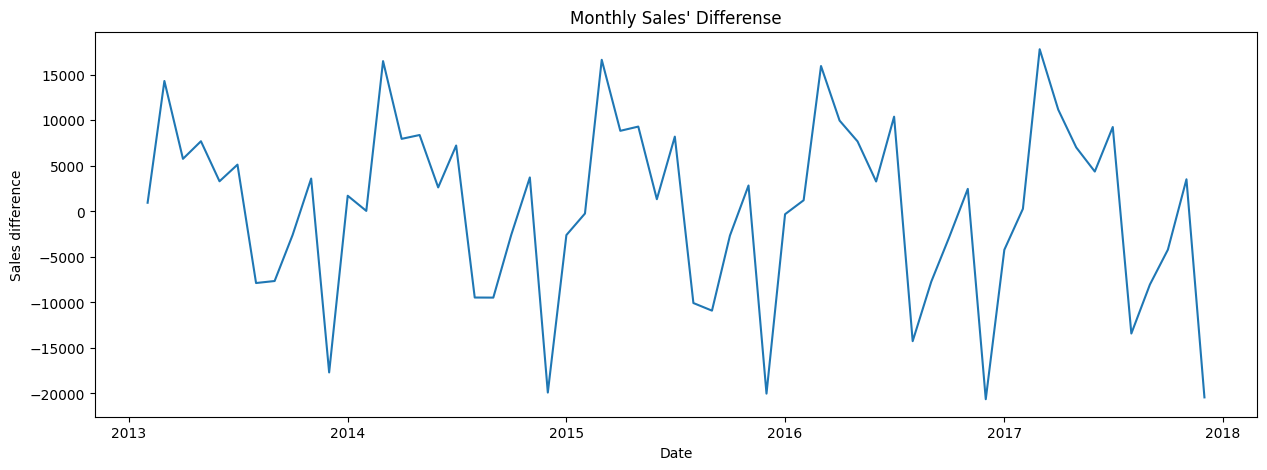

In [17]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("Sales difference")
plt.title("Monthly Sales' Differense")
plt.show()

Dropping off sales and date

In [18]:
supervised_data = monthly_sales.drop(["date", "sales"], axis = 1)

Preparing the supervised data

In [19]:
for i in range(1,13):
  col_name = 'Month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)

In [20]:
supervised_data.head(10)

,sales_diff,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0,7709.0,5776.0,14330.0,953.0
1,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0,7709.0,5776.0,14330.0
2,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0,7709.0,5776.0
3,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0,7709.0
4,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0
5,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0
6,-9459.0,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0
7,-9468.0,-9459.0,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0
8,-2567.0,-9468.0,-9459.0,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0
9,3734.0,-2567.0,-9468.0,-9459.0,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0


Now we have sales' differences for each store particulary in each month

Let's move on to train/test data split

In [21]:
train_data, test_data = supervised_data[:-12], supervised_data[-12:] # for prev 12 months and upcoming 12 months respectively
train_data.shape

(35, 13)

In [22]:
test_data.shape

(12, 13)

In [23]:
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [24]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train shape: ", x_train.shape)
print("X_test shape: ", x_test.shape)
print("Y_train shape: ", y_train.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (35, 12)
X_test shape:  (12, 12)
Y_train shape:  (35,)
Y_test shape:  (12,)


Make prediction data frame to merge the predicted sale prices of all trained algos

In [25]:
sales_dates = monthly_sales["date"][-12:].reset_index(drop = True)
predict_df = pd.DataFrame(sales_dates)

In [26]:
act_sales = monthly_sales["sales"][-13:].to_list()
act_sales

[59839,
 55624,
 55910,
 73727,
 84902,
 91933,
 96313,
 105585,
 92172,
 84141,
 79941,
 83472,
 63044]

Linear Regression


In [27]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

In [28]:
lr_pred = lr_pred.reshape(-1,1)
lr_pred_test_set = np.concatenate([lr_pred, x_test], axis = 1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)

In [29]:
result_list = []
for i in range(0,len(lr_pred_test_set)):
  result_list.append(lr_pred_test_set[i][0] + act_sales[i])
lr_pred_series = pd.Series(result_list, name = "Linear Prediction")
predict_df = predict_df.merge(lr_pred_series, left_index = True, right_index = True)

In [30]:
lr_mse = np.sqrt(mean_squared_error(predict_df["Linear Prediction"], monthly_sales["sales"][-12:]))
lr_mae = mean_absolute_error(predict_df["Linear Prediction"], monthly_sales["sales"][-12:])
lr_r2 = r2_score(predict_df["Linear Prediction"], monthly_sales["sales"][-12:])

print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  1557.3766410406454
Linear Regression MAE:  1213.516858583377
Linear Regression R2:  0.9893135205584865


Visualization of results

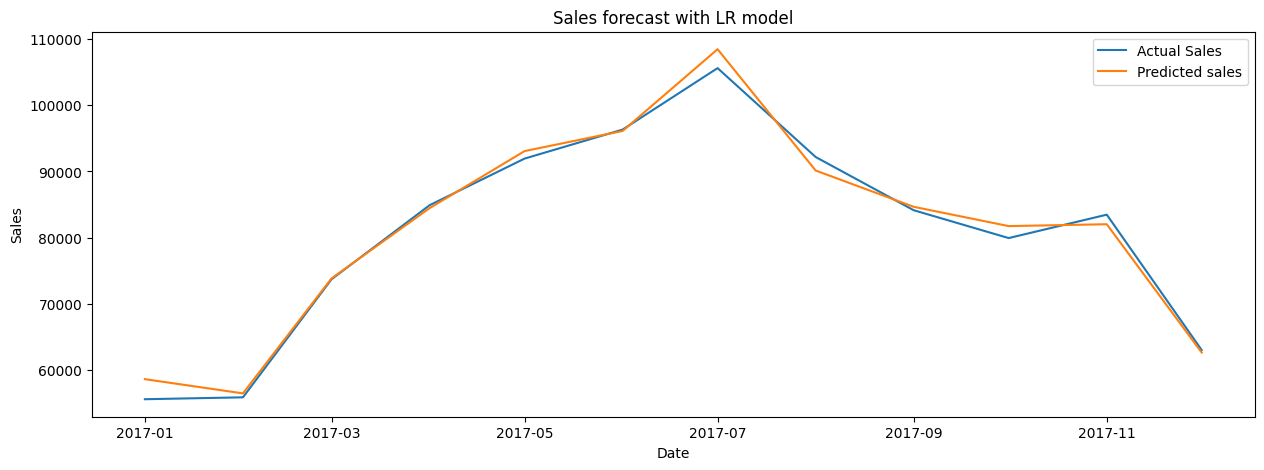

In [31]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales["date"][-12:], monthly_sales["sales"][-12:])
plt.plot(predict_df["date"], predict_df["Linear Prediction"])
plt.title("Sales forecast with LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Actual Sales", "Predicted sales"])
plt.show()

Random Forest

In [32]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

In [33]:
rf_pred = rf_pred.reshape(-1,1)
rf_pred_test_set = np.concatenate([rf_pred, x_test], axis = 1)
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)

In [34]:
result_list = []
for i in range(0,len(rf_pred_test_set)):
  result_list.append(rf_pred_test_set[i][0] + act_sales[i])
rf_pred_series = pd.Series(result_list, name = "Random Forest Prediction")
predict_df = predict_df.merge(rf_pred_series, left_index = True, right_index = True)

In [37]:
rf_mse = np.sqrt(mean_squared_error(predict_df["Random Forest Prediction"], monthly_sales["sales"][-12:]))
rf_mae = mean_absolute_error(predict_df["Random Forest Prediction"], monthly_sales["sales"][-12:])
rf_r2 = r2_score(predict_df["Random Forest Prediction"], monthly_sales["sales"][-12:])

print("Random Forest MSE: ", rf_mse)
print("Random Forest MAE: ", rf_mae)
print("Random Forest R2: ", rf_r2)

Random Forest MSE:  1721.0906705294003
Random Forest MAE:  1529.4783333333355
Random Forest R2:  0.9862950735942014


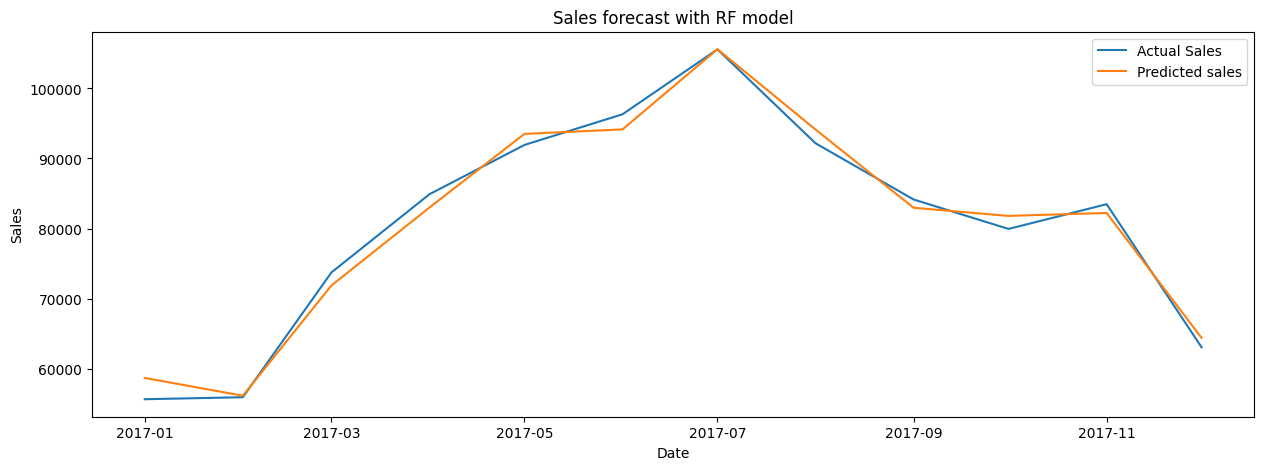

In [36]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales["date"][-12:], monthly_sales["sales"][-12:])
plt.plot(predict_df["date"], predict_df["Random Forest Prediction"])
plt.title("Sales forecast with RF model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Actual Sales", "Predicted sales"])
plt.show()

XGBoost

In [65]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)

In [66]:
xgb_pred = xgb_pred.reshape(-1,1)
xgb_pred_test_set = np.concatenate([xgb_pred, x_test], axis = 1)
xgb_pred_test_set = scaler.inverse_transform(xgb_pred_test_set)

In [67]:
result_list = []
for i in range(0,len(xgb_pred_test_set)):
  result_list.append(xgb_pred_test_set[i][0] + act_sales[i])
xgb_pred_series = pd.Series(result_list, name = "XGBoost Regressor Prediction")
predict_df = predict_df.merge(xgb_pred_series, left_index = True, right_index = True)

In [68]:
xgb_mse = np.sqrt(mean_squared_error(predict_df["XGBoost Regressor Prediction"], monthly_sales["sales"][-12:]))
xgb_mae = mean_absolute_error(predict_df["XGBoost Regressor Prediction"], monthly_sales["sales"][-12:])
xgb_r2 = r2_score(predict_df["XGBoost Regressor Prediction"], monthly_sales["sales"][-12:])

print("XGBoost MSE: ", xgb_mse)
print("XGBoost MAE: ", xgb_mae)
print("XGBoost R2: ", xgb_r2)

XGBoost MSE:  1855.9228079920297
XGBoost MAE:  1449.332088560487
XGBoost R2:  0.9843306479008976


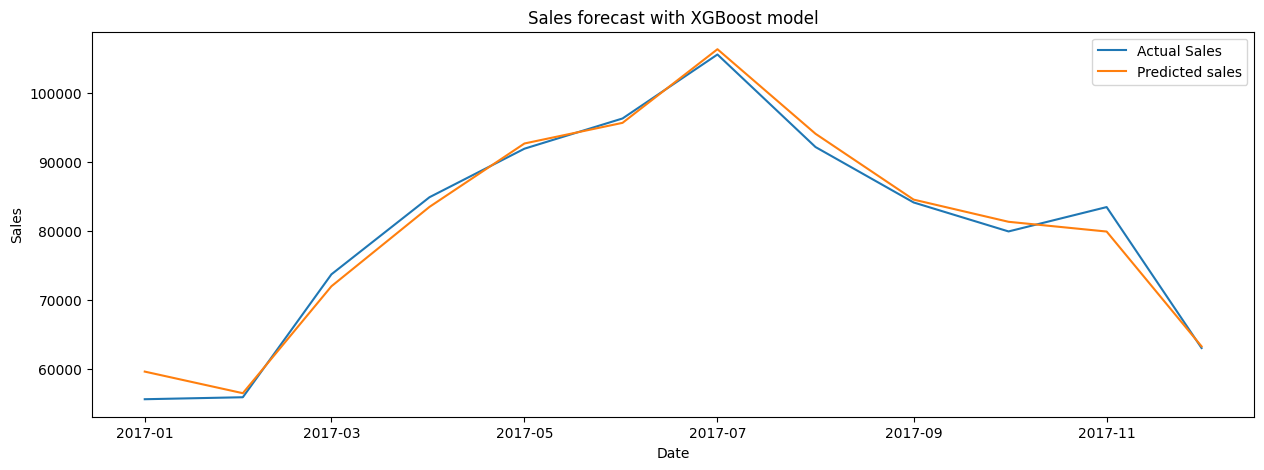

In [69]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales["date"][-12:], monthly_sales["sales"][-12:])
plt.plot(predict_df["date"], predict_df["XGBoost Regressor Prediction"])
plt.title("Sales forecast with XGBoost model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Actual Sales", "Predicted sales"])
plt.show()

The best result is shown by Linear Regression Model

In [70]:
store_sales_test = pd.read_csv("test.csv")
store_sales_test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [71]:
store_sales_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
